**A stock contest**

You are the key player in a stock contest. Your strategy is the following : part of the profit is reinvested, and the rest is saved. Surely you need to prove your investment skills at adjusting the reinvestment-ratio.

Given the seed money and the end time of the contest, you need to maximize your total profit.

**Question 3.**

* We **do not** have a priori bang-bang assumption.
* We completely know **the closed form of the payoff functional(=total profit)**.
* We do not know how to maximize the total profit.
* We know machine learning.


Q. By using machine learning technique, find the optimal investment strategy.

Payoff functional :
$$ P[\alpha(\cdot)] = \int^T_0 (1-\alpha (t))x(t) dt $$
where $\alpha $ is a fraction of output reinvested at time $t\geq 0$.

Training started...
Epoch 0, Loss(Neg Profit): -2.1793
Epoch 100, Loss(Neg Profit): -2.9996
Epoch 200, Loss(Neg Profit): -3.0005
Epoch 300, Loss(Neg Profit): -3.0459
Epoch 400, Loss(Neg Profit): -3.0466
Training finished.


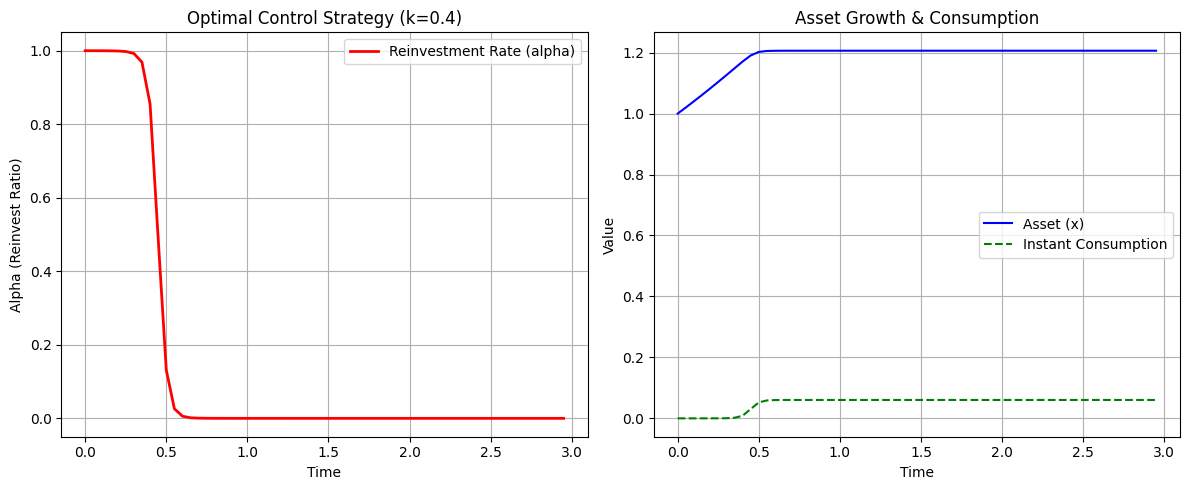

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 1. 환경 설정 (Class)
class InvestEnv:
    def __init__(self, k=0.5, T=10.0, dt=0.1, x_0=1.0):
        self.k = k
        self.T = T
        self.dt = dt
        self.x_0 = x_0
        self.reset()

    def reset(self):
        self.t = 0.0
        # Gradients 흐름을 위해 requires_grad=False (초기값은 상수)
        self.x = torch.tensor([self.x_0], dtype=torch.float32)
        return self.t, self.x

    def productive_step(self, alpha):
        # 1. 보상 (소비) 계산
        reward = (1 - alpha) * self.x * self.dt
        
        # 2. Dynamics (자산 성장)
        # x는 텐서이므로 연산 그래프가 유지됨
        x_dot = self.k * alpha * self.x
        self.x = self.x + x_dot * self.dt
        
        # 3. 시간 경과
        self.t += self.dt
        done = self.t >= self.T - (self.dt / 2) # 부동소수점 오차 보정
        
        return self.x, reward, done

# 2. 신경망 모델 (Policy Network)
class InvestNet(nn.Module):
    def __init__(self):
        super(InvestNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), 
            nn.Tanh(),        # ReLU보다 곡선 표현에 유리할 수 있음
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Sigmoid()      # 0~1 사이의 alpha 값 출력
        )
    
    def forward(self, t):
        # t가 스칼라로 들어오더라도 텐서 (N, 1) 형태로 변환
        if not isinstance(t, torch.Tensor):
            t = torch.tensor([t], dtype=torch.float32)
        return self.net(t)

# 3. 학습 및 시각화 함수
def TrainAndVisualize():
    # 설정
    k_val = 0.4
    env = InvestEnv(k=k_val, T=3.0, dt=0.05, x_0=1.0)
    model = InvestNet()
    optimizer = optim.Adam(model.parameters(), lr=0.005) # 학습률 조정

    epochs = 500
    steps = int(env.T / env.dt)
    
    loss_history = []

    print("Training started...")
    
    for epoch in range(epochs):
        # [중요] 매 에포크마다 환경 리셋
        env.reset()
        
        total_consumption = 0
        current_x = env.x # 초기 상태
        
        # [중요] 한 에피소드(0 ~ T)를 처음부터 끝까지 시뮬레이션
        for i in range(steps):
            t_tensor = torch.tensor([env.t], dtype=torch.float32)
            
            # 모델이 행동(alpha) 결정
            alpha = model(t_tensor)
            
            # 환경에 행동 적용 (Environment의 로직 활용)
            current_x, reward, done = env.productive_step(alpha)
            
            total_consumption += reward

        # 손실 함수: 총 소비량의 음수 (Maximize Profit -> Minimize Negative Profit)
        loss = -total_consumption
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss(Neg Profit): {loss.item():.4f}")

    print("Training finished.")

    # --- 4. 결과 시각화 (Inference) ---
    model.eval() # 평가 모드
    env.reset()
    
    times = []
    alphas = []
    assets = []
    consumptions = []
    
    with torch.no_grad(): # 그래디언트 계산 불필요
        for i in range(steps):
            t_val = env.t
            t_tensor = torch.tensor([t_val], dtype=torch.float32)
            alpha = model(t_tensor)
            
            # 기록
            times.append(t_val)
            alphas.append(alpha.item())
            assets.append(env.x.item())
            
            # 환경 진행
            x_next, reward, done = env.productive_step(alpha)
            consumptions.append(reward.item())

    # 그래프 그리기
    plt.figure(figsize=(12, 5))

    # 그래프 1: 투자 전략 (Alpha)
    plt.subplot(1, 2, 1)
    plt.plot(times, alphas, label='Reinvestment Rate (alpha)', color='r', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Alpha (Reinvest Ratio)')
    plt.title(f'Optimal Control Strategy (k={k_val})')
    plt.grid(True)
    plt.legend()

    # 그래프 2: 자산 및 소비
    plt.subplot(1, 2, 2)
    plt.plot(times, assets, label='Asset (x)', color='b')
    # 소비율은 alpha와 반대 경향을 보임
    plt.plot(times, consumptions, label='Instant Consumption', color='g', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Asset Growth & Consumption')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# 실행
TrainAndVisualize()

Training started...
Epoch 0, Loss(Neg Profit): -2.0128
Epoch 100, Loss(Neg Profit): -3.0442
Epoch 200, Loss(Neg Profit): -3.0460
Epoch 300, Loss(Neg Profit): -3.0465
Epoch 400, Loss(Neg Profit): -3.0469
Training finished.


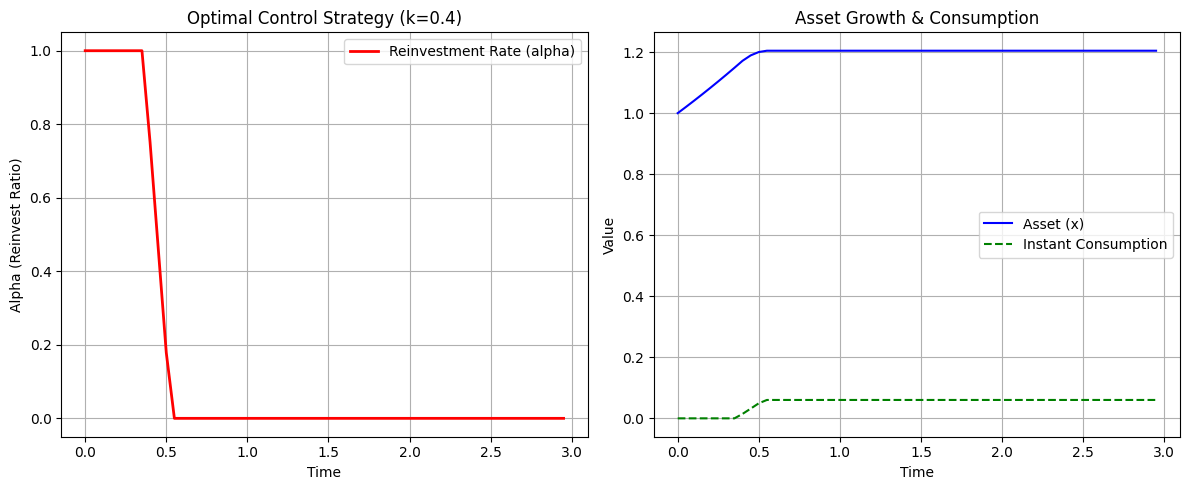

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 1. 환경 설정 (Class)
class InvestEnv:
    def __init__(self, k=0.5, T=10.0, dt=0.1, x_0=1.0):
        self.k = k
        self.T = T
        self.dt = dt
        self.x_0 = x_0
        self.reset()

    def reset(self):
        self.t = 0.0
        # Gradients 흐름을 위해 requires_grad=False (초기값은 상수)
        self.x = torch.tensor([self.x_0], dtype=torch.float32)
        return self.t, self.x

    def productive_step(self, alpha):
        # 1. 보상 (소비) 계산
        reward = (1 - alpha) * self.x * self.dt
        
        # 2. Dynamics (자산 성장)
        # x는 텐서이므로 연산 그래프가 유지됨
        x_dot = self.k * alpha * self.x
        self.x = self.x + x_dot * self.dt
        
        # 3. 시간 경과
        self.t += self.dt
        done = self.t >= self.T - (self.dt / 2) # 부동소수점 오차 보정
        
        return self.x, reward, done

# 2. 신경망 모델 (Policy Network)
class InvestNet(nn.Module):
    def __init__(self):
        super(InvestNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), 
            nn.Tanh(),        # ReLU보다 곡선 표현에 유리할 수 있음
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Hardsigmoid()     # 0~1 사이의 alpha 값 출력
        )
    
    def forward(self, t):
        # t가 스칼라로 들어오더라도 텐서 (N, 1) 형태로 변환
        if not isinstance(t, torch.Tensor):
            t = torch.tensor([t], dtype=torch.float32)
        return self.net(t)

# 3. 학습 및 시각화 함수
def TrainAndVisualize():
    # 설정
    k_val = 0.4
    env = InvestEnv(k=k_val, T=3.0, dt=0.05, x_0=1.0)
    model = InvestNet()
    optimizer = optim.Adam(model.parameters(), lr=0.005) # 학습률 조정

    epochs = 500
    steps = int(env.T / env.dt)
    
    loss_history = []

    print("Training started...")
    
    for epoch in range(epochs):
        # [중요] 매 에포크마다 환경 리셋
        env.reset()
        
        total_consumption = 0
        current_x = env.x # 초기 상태
        
        # [중요] 한 에피소드(0 ~ T)를 처음부터 끝까지 시뮬레이션
        for i in range(steps):
            t_tensor = torch.tensor([env.t], dtype=torch.float32)
            
            # 모델이 행동(alpha) 결정
            alpha = model(t_tensor)
            
            # 환경에 행동 적용 (Environment의 로직 활용)
            current_x, reward, done = env.productive_step(alpha)
            
            total_consumption += reward

        # 손실 함수: 총 소비량의 음수 (Maximize Profit -> Minimize Negative Profit)
        loss = -total_consumption
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss(Neg Profit): {loss.item():.4f}")

    print("Training finished.")

    # --- 4. 결과 시각화 (Inference) ---
    model.eval() # 평가 모드
    env.reset()
    
    times = []
    alphas = []
    assets = []
    consumptions = []
    
    with torch.no_grad(): # 그래디언트 계산 불필요
        for i in range(steps):
            t_val = env.t
            t_tensor = torch.tensor([t_val], dtype=torch.float32)
            alpha = model(t_tensor)
            
            # 기록
            times.append(t_val)
            alphas.append(alpha.item())
            assets.append(env.x.item())
            
            # 환경 진행
            x_next, reward, done = env.productive_step(alpha)
            consumptions.append(reward.item())

    # 그래프 그리기
    plt.figure(figsize=(12, 5))

    # 그래프 1: 투자 전략 (Alpha)
    plt.subplot(1, 2, 1)
    plt.plot(times, alphas, label='Reinvestment Rate (alpha)', color='r', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Alpha (Reinvest Ratio)')
    plt.title(f'Optimal Control Strategy (k={k_val})')
    plt.grid(True)
    plt.legend()

    # 그래프 2: 자산 및 소비
    plt.subplot(1, 2, 2)
    plt.plot(times, assets, label='Asset (x)', color='b')
    # 소비율은 alpha와 반대 경향을 보임
    plt.plot(times, consumptions, label='Instant Consumption', color='g', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Asset Growth & Consumption')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# 실행
TrainAndVisualize()